In [1]:
# Import necessary libraries
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from filterpy.kalman import KalmanFilter
import optuna
import pickle
import yfinance as yf

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sktime.forecasting.model_selection import SlidingWindowSplitter

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Specify the stock ticker to download and date range
ticker = "MSFT"
start_date = "2002-01-07"
end_date = "2025-03-07"

# Download the data
indv_stock = yf.download(ticker, start=start_date, end=end_date)

# Reset index to move dates to a column and convert it to datetime
indv_stock = indv_stock.reset_index()
indv_stock['Date']=pd.to_datetime(indv_stock['Date'])

# Print the data (optional)
print(indv_stock.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price        Date      Close       High        Low       Open    Volume
Ticker                  MSFT       MSFT       MSFT       MSFT      MSFT
0      2002-01-07  21.052399  21.500714  20.987915  21.417807  58508800
1      2002-01-08  21.304193  21.451586  20.880444  21.092320  47736400
2      2002-01-09  21.098459  21.684955  21.049330  21.408596  76304000
3      2002-01-10  21.273491  21.433166  20.920365  21.027840  50296600
4      2002-01-11  21.067749  21.592830  20.911145  21.347177  72993200


In [3]:
# Calculate daily return and price range metrics as percentages
indv_stock['Return']=100*(indv_stock['Close']-indv_stock['Open'])/indv_stock['Open']
indv_stock['HighR']=100*(indv_stock['High']-indv_stock['Open'])/indv_stock['Open']
indv_stock['LowR']=100*(indv_stock['Low']-indv_stock['Open'])/indv_stock['Open']
indv_stock['Volatility']=indv_stock['Return'].rolling(window=3).std()

# Clean up dataframe structure and data preparation
indv_stock.columns = indv_stock.columns.droplevel(1)
indv_stock["Volume"] = np.log(1+indv_stock["Volume"])

columns=['Date','Return','Volatility','HighR','LowR', 'Close', 'Volume']
final_indv_stock=indv_stock[columns]


final_indv_stock.dropna(inplace=True)
final_indv_stock=final_indv_stock.reset_index(drop=True)
final_indv_stock = final_indv_stock.rename_axis(None, axis=1)
final_indv_stock.head()

,Date,Return,Volatility,HighR,LowR,Close,Volume
0,2002-01-09,-1.448655,1.496197,1.290880,-1.678138,21.098459,18.150236
1,2002-01-10,1.168218,1.465880,1.927570,-0.511107,21.273491,17.733448
2,2002-01-11,-1.308970,1.472186,1.150752,-2.042575,21.067749,18.105877
3,2002-01-14,0.248899,1.252235,1.083452,-0.819920,21.024763,17.747293
4,2002-01-15,1.296241,1.310916,1.398193,-0.233038,21.356398,17.921741


In [4]:
# Kalman smoother function
def kalman_smooth(series, q):
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([[series.iloc[0]], [0.]])
    kf.F = np.array([[1., 1.], [0., 1.]])
    kf.H = np.array([[1., 0.]])
    kf.P *= 1000.
    kf.R = np.var(series) * 0.5
    kf.Q = np.array([[q, 0.], [0., q]])

    result = []
    for val in series:
        kf.predict()
        kf.update(val)
        result.append(kf.x[0, 0])
    return result

In [5]:
def objective_with_args(df):
    def inner(trial):
        df_local = df.copy()
        smooth_errors = []

        for feature in features:
            q = trial.suggest_float(f"q_{feature}", 1e-6, 1e-3, log=True)
            series = df_local[feature]
            if feature == "Volume":
                series = np.log(series + 1e-6)  # avoid log(0)
            smooth = kalman_smooth(series, q)
            df_local[f"Smooth_{feature}"] = smooth

            # Add a proxy error metric: how far is the smoothed series from the original?
            mse = np.mean((series.iloc[1:] - np.array(smooth[1:]))**2)
            smooth_errors.append(mse)

        return -np.mean(smooth_errors)  # Negative so Optuna maximizes smoothness quality

    return inner

In [6]:
# Clean dataset
indv_stock.dropna(inplace=True)
indv_stock=indv_stock.reset_index(drop=True)
indv_stock = indv_stock.rename_axis(None, axis=1)
indv_stock['Ticker'] = 'MSFT'
data_full = [indv_stock]
data_full[0].head()

,Date,Close,High,Low,Open,Volume,Return,HighR,LowR,Volatility,Ticker
0,2002-01-09,21.098459,21.684955,21.049330,21.408596,18.150236,-1.448655,1.290880,-1.678138,1.496197,MSFT
1,2002-01-10,21.273491,21.433166,20.920365,21.027840,17.733448,1.168218,1.927570,-0.511107,1.465880,MSFT
2,2002-01-11,21.067749,21.592830,20.911145,21.347177,18.105877,-1.308970,1.150752,-2.042575,1.472186,MSFT
3,2002-01-14,21.024763,21.199790,20.800604,20.972563,17.747293,0.248899,1.083452,-0.819920,1.252235,MSFT
4,2002-01-15,21.356398,21.377892,21.033978,21.083110,17.921741,1.296241,1.398193,-0.233038,1.310916,MSFT


In [7]:
## Applying Kalman smoothing technique
stocks_new = ['MSFT']
features=['Return','Volatility','HighR','LowR',"Volume"]


data = [final_indv_stock[features]]
data_with_date=[x[features+["Date"]] for x in data_full]

for s_ind in range(len(stocks_new)):
    print(f"Tuning Kalman smoothing for stock: {stocks_new[s_ind]}")
    df_stock = data[s_ind]

    study = optuna.create_study(direction="maximize")
    study.optimize(objective_with_args(df_stock), n_trials=50)

    best_qs = study.best_params

    # Apply best Qs to full data and store smoothed features
    for feature in features:
        series = data_with_date[s_ind][feature]
        data_with_date[s_ind][f"Smooth_{feature}"] = kalman_smooth(series, best_qs[f"q_{feature}"])


[I 2025-04-21 22:57:34,314] A new study created in memory with name: no-name-4d7e99b5-b904-49d2-a3c7-4ed89e617bab


Tuning Kalman smoothing for stock: MSFT


[I 2025-04-21 22:57:34,681] Trial 0 finished with value: -0.6396600633364199 and parameters: {'q_Return': 0.0002183810016517893, 'q_Volatility': 6.617335185477386e-05, 'q_HighR': 6.825940100655728e-05, 'q_LowR': 0.0002841973472024811, 'q_Volume': 1.6056091943243455e-06}. Best is trial 0 with value: -0.6396600633364199.
[I 2025-04-21 22:57:35,024] Trial 1 finished with value: -0.6974607117729884 and parameters: {'q_Return': 2.0858457595438533e-06, 'q_Volatility': 0.0008416254468989342, 'q_HighR': 2.2326088958234014e-06, 'q_LowR': 9.69341925198338e-05, 'q_Volume': 0.0003370412785277561}. Best is trial 0 with value: -0.6396600633364199.
[I 2025-04-21 22:57:35,365] Trial 2 finished with value: -0.6519631121118767 and parameters: {'q_Return': 3.672436327967496e-05, 'q_Volatility': 0.0005763212500496862, 'q_HighR': 1.1057719168902116e-05, 'q_LowR': 0.0006535015364834316, 'q_Volume': 4.1882716098731495e-06}. Best is trial 0 with value: -0.6396600633364199.
[I 2025-04-21 22:57:35,718] Trial 3 

In [8]:
# Function to plot the hidden states
def plot_in_sample_hidden_states(df):
    hidden_states = df['State']
    # Create the correctly formatted plot
    fig, ax = plt.subplots()
    state_colors = {0: 'green', 1: 'red'}

    for state, color in state_colors.items():
        mask = hidden_states == state
        ax.plot(
            df.index[mask],
            df["Close"][mask],
            ".", linestyle='none',
            c=color,
            label=f"State {state}"
        )
# Format x-axis with years
    ax.xaxis.set_major_locator(mdates.YearLocator())      # one tick per year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # format tick labels as YYYY
    fig.autofmt_xdate()  # Rotate labels automatically

    ax.set_title("In-Sample Hidden States")
    ax.set_xlabel("Year")
    ax.set_ylabel("Close Price")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

In [9]:
# Final data preparation
smooth_features = [f"Smooth_{feature}" for feature in features]
smooth_features.append("Volatility")
smooth_features.remove("Smooth_Volatility")
smooth_data = [x[smooth_features] for x in data_with_date]
smooth_data_with_date = [x[smooth_features+["Date"]] for x in data_with_date]

In [10]:
# Apply GaussianHMM model
models=[]
for x in smooth_data_with_date:
    modl=GaussianHMM(n_components=2,n_iter=10000,tol=1e-5)
    modl.fit(x[smooth_features])
    models.append(modl)

def regime(state_info):
    return state_info[1] #returns volatility for now

In [11]:
l=[] #stores the mean feature values across stocks
for (i,x) in enumerate(smooth_data_with_date):
    x['State']=pd.Series(models[i].predict(x[smooth_features]))
    state_0 = x[x['State']==0].mean()
    state_1 = x[x['State']==1].mean()
    l.append((state_0,state_1))
    [a,b]  = list(map(regime, [state_0,state_1]))
    if a > b:
        x['State']=1-x['State']
    x['Ticker']=stocks_new[i]
    x["Close"] = data_full[i]["Close"]

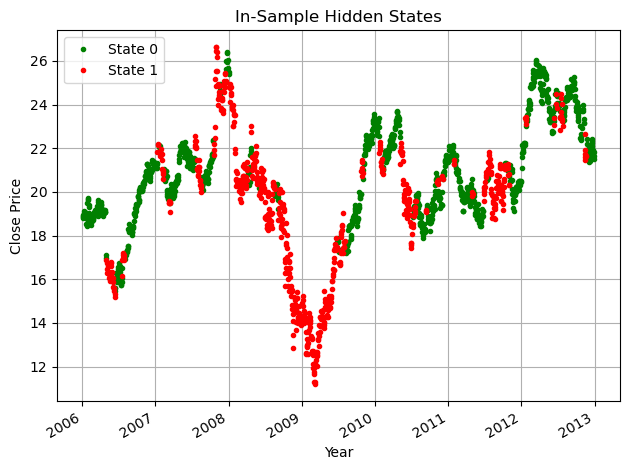

Plot for MSFT


In [12]:
# Plot the hidden states
for i in range(len(stocks_new)):
    stock = smooth_data_with_date[i]
    df= stock[stock["Date"].dt.year.isin(range(2006,2013))].reset_index(drop=True)
    df.set_index('Date', inplace=True)
    plot_in_sample_hidden_states(df)
    print(f"Plot for {stocks_new[i]}")

In [13]:
# Save the data
total=pd.concat(smooth_data_with_date).reset_index(drop=True)
total.head()
total.to_csv('stock_msft_hmm_output_kalman.csv')

### Test

In [14]:
## Select the stock and best models
stocks=['MSFT']
best_spreads=[6]

init_dir_path = str(os.getcwd())

In [15]:
# Test on unsmoothened features but kalman target
data = indv_stock
smooth_data=pd.read_csv(init_dir_path+'/stock_msft_hmm_output_kalman.csv',engine='python').drop(['Unnamed: 0'],axis=1)
features=['Return','Volatility','HighR','LowR']
target='State'
data[target] = smooth_data[target] 
data.head()

,Date,Close,High,Low,Open,Volume,Return,HighR,LowR,Volatility,Ticker,State
0,2002-01-09,21.098459,21.684955,21.049330,21.408596,18.150236,-1.448655,1.290880,-1.678138,1.496197,MSFT,1
1,2002-01-10,21.273491,21.433166,20.920365,21.027840,17.733448,1.168218,1.927570,-0.511107,1.465880,MSFT,1
2,2002-01-11,21.067749,21.592830,20.911145,21.347177,18.105877,-1.308970,1.150752,-2.042575,1.472186,MSFT,1
3,2002-01-14,21.024763,21.199790,20.800604,20.972563,17.747293,0.248899,1.083452,-0.819920,1.252235,MSFT,1
4,2002-01-15,21.356398,21.377892,21.033978,21.083110,17.921741,1.296241,1.398193,-0.233038,1.310916,MSFT,1


In [16]:
final_test=[]
stocks_data=[]
ft_size=400
for x in data.groupby(['Ticker']):
    final_test.append(x[1][-ft_size:])
    stocks_data.append(x[1][:-ft_size])

In [17]:
# Create sliding window
def create_sliding_window(train_df, features, target, window=7):
    splitter = SlidingWindowSplitter(window_length=window, step_length=1, fh=[1])
    train_x, train_y= [], []

    for idx in splitter.split(train_df):
        X = train_df.iloc[idx[0]][features].values.flatten()
        y = train_df.iloc[idx[1]][target].values.flatten()[0]
        train_x.append(X)
        train_y.append(y)

    return (train_x, train_y)

In [18]:
testing_lists = {}
for ticker_idx, ticker_df in enumerate(final_test):
    ticker = list(ticker_df["Ticker"])[0]
    (test_x, test_y) = create_sliding_window(ticker_df, features, target, window=best_spreads[ticker_idx])
    testing_lists[ticker] = [test_x,test_y] #spread->stock index->time series split->data/label

In [20]:
# Load the best Google model
with open('pickles/best_logistic_googl.pkl', 'rb') as f:
    model = pickle.load(f)

In [21]:
# Calculate the accuracies
accuracies=pd.DataFrame(index=['f1_score','accuracy_score','baseline_f1','baseline_accuracy'])
for (i,stock) in enumerate(stocks):
    y_pred=model.predict(testing_lists[stock][0])
    y_true=testing_lists[stock][1]
    y_naive=[0]*len(y_true)
    accuracies[stock]=[f1_score(y_pred,y_true,pos_label=0),accuracy_score(y_pred,y_true),f1_score(y_true,y_naive,pos_label=0),accuracy_score(y_true,y_naive)]

accuracies

,MSFT
f1_score,0.980663
accuracy_score,0.964467
baseline_f1,0.957672
baseline_accuracy,0.918782


### End